### DRM experiment simulation - extended model

The Deese-Roediger-McDermott task is a classic way to measure memory distortion. This notebook tries to recreate the human results in VAE and AE models.

#### Installation:

In [ ]:
!pip install tensorflow==2.11.0
!pip install tensorflow-datasets
!pip install tfds-nightly
!pip install scikit-learn --upgrade

#### Imports:

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from config import DRM_lists, lures
from data_preparation import *
from generative_model import *
from hopfield_models import *
from itertools import groupby
from operator import itemgetter
from math import sqrt
import random

tf.random.set_seed(1234)

#### VAE pre-training

In [2]:
x_train, vectorizer = prepare_data(max_df=0.1, min_df=0.0005, ids=False)

# vae = train_vae(x_train, vectorizer, eps=100, ld=300, beta=0.001, batch=128, l1_value=0.01,
#                 model_save_path='300ld_100eps_0.001beta_128batch_0.01l1.h5')

#### Load model

In [3]:
model_weights_path = '300ld_100eps_0.001beta_128batch_0.01l1.h5'
vae = load_vae(vectorizer, ld=300, beta=0.001, 
               model_weights_path=model_weights_path)

_, id_vectorizer = prepare_data(max_df=0.1, min_df=0.0005, ids=True)

2023-08-10 17:58:01.199029: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-10 17:58:01.199410: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro


#### Extended model - store latent codes plus IDs:

In [4]:
# create lists with additional unique spatiotemporal features:
def create_experiences(num=None):
    if num is None:
        experiences = [' '.join([f'id_{n}'] + l) for n, l in enumerate(list(DRM_data.values()))]
    else:
        experiences = [' '.join([f'id_{n}'] + l[0:num]) for n, l in enumerate(list(DRM_data.values()))]
    print("Example list with unique spatiotemporal feature:")
    print(experiences[0])
    return experiences

In [5]:
# set latent dimension
ld = 300    

def get_latent_code(sent):
    encoded = vae.encoder.predict(vectorizer.transform([sent]))[0]
    return encoded

def encode_patterns(experiences):
    # create MHN with dimension ld + id_vectorizer vocabulary size
    net = ContinuousHopfield(ld + len(id_vectorizer.vocabulary_.keys()),
                             beta=100,
                             do_normalization=False)
    
    patterns = []
    for test_text in experiences:
        # get latent code for list
        latent = get_latent_code(test_text)
        # flatten latent to 1D array
        latent = latent.flatten()  
        # get vector representing unique spatiotemporal context
        id_counts = id_vectorizer.transform([test_text.split()[0]]).toarray()
        # check unique spatiotemporal context
        print(id_vectorizer.inverse_transform(id_counts))
        id_counts = id_counts.flatten() 
        pattern = list(latent) + list(id_counts)
        patterns.append(pattern)
    
    patterns = [np.array(p).reshape(-1, 1) for p in patterns]
    net.learn(np.array(patterns))
    return net

#### Test recall:

Example list with unique spatiotemporal feature:
id_0 fear temper hatred fury happy enrage emotion rage hate mean ire mad wrath calm fight
100
1/1 [==============================] - 0s 232ms/step
[array(['id_0'], dtype='<U14')]
1/1 [==============================] - 0s 17ms/step
[array(['id_1'], dtype='<U14')]
1/1 [==============================] - 0s 5ms/step


2023-08-10 17:58:40.691336: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-10 17:58:40.692442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[array(['id_2'], dtype='<U14')]
1/1 [==============================] - 0s 15ms/step
[array(['id_3'], dtype='<U14')]
1/1 [==============================] - 0s 5ms/step
[array(['id_4'], dtype='<U14')]
1/1 [==============================] - 0s 10ms/step
[array(['id_5'], dtype='<U14')]
1/1 [==============================] - 0s 21ms/step
[array(['id_6'], dtype='<U14')]
1/1 [==============================] - 0s 19ms/step
[array(['id_7'], dtype='<U14')]
1/1 [==============================] - 0s 6ms/step
[array(['id_8'], dtype='<U14')]
1/1 [==============================] - 0s 16ms/step
[array(['id_9'], dtype='<U14')]
1/1 [==============================] - 0s 5ms/step
[array(['id_10'], dtype='<U14')]
1/1 [==============================] - 0s 15ms/step
[array(['id_11'], dtype='<U14')]
1/1 [==============================] - 0s 5ms/step
[array(['id_12'], dtype='<U14')]
1/1 [==============================] - 0s 5ms/step
[array(['id_13'], dtype='<U14')]
1/1 [==============================] - 0s 14m

2023-08-10 17:58:41.367096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step


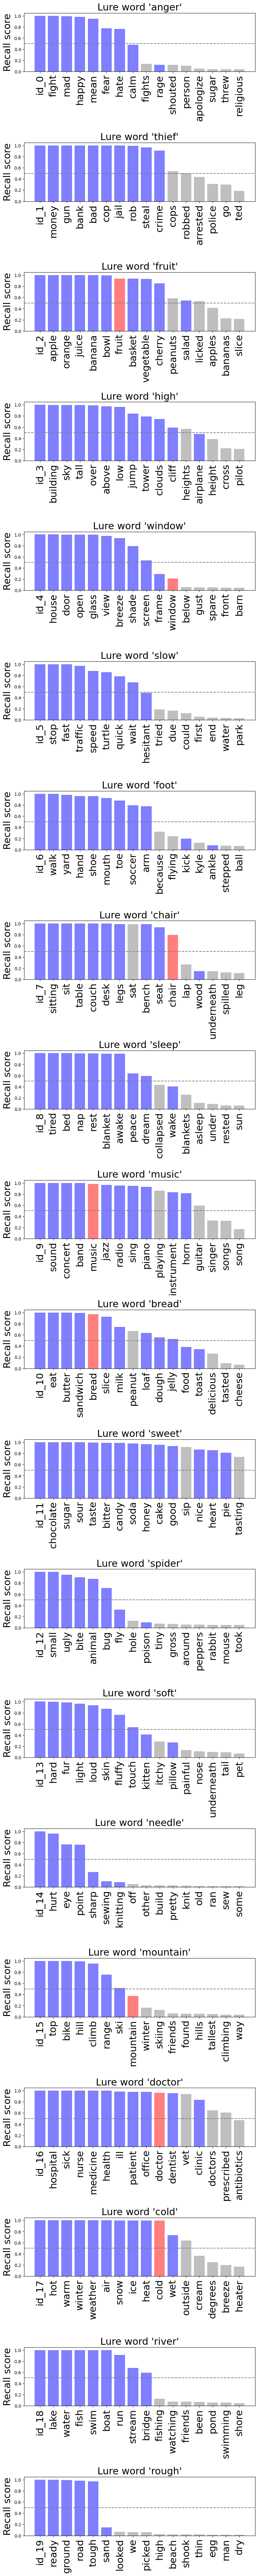

In [6]:
def hybrid_recall(test_text, net):
    latent = np.full((1, ld), 0)
    latent = latent.flatten()  # flatten latent to 1D array
    id_counts = id_vectorizer.transform([test_text]).toarray()
    id_counts = id_counts.flatten()  # flatten id_counts to 1D array
    pattern = list(latent) + list(id_counts)  # concatenating two lists

    memory = net.retrieve(np.array(pattern).reshape(-1, 1))
    
    decoded = vae.decoder.predict(memory[0:ld].reshape((1,ld)))
    top_words = [(word_lookup[index], decoded[0][index]) for index in np.argsort(-decoded)[0]][0:15]

    unpredictable_component = id_vectorizer.inverse_transform(np.array(memory[ld:]).reshape((1, 4226)))
    recalled_words = [tuple((unpredictable_component[0][0], 1))] + list(top_words)
    return recalled_words

def hybrid_plot(ax, terms, scores, clrs, lure_word):
    ax.bar(terms, scores, color=clrs, alpha=0.5)
    ax.axhline(y=0.5, color='grey', linestyle='--') # Add a dashed line at y=0.5
    ax.set_ylabel('Recall score', fontsize=22)
    ax.set_title(f"Lure word '{lure_word}'", fontsize=22)
    plt.sca(ax)
    plt.xticks(rotation=90, fontsize=22)

word_lookup = {v:k for k,v in vectorizer.vocabulary_.items()}

fig, axs = plt.subplots(len(lures), 1, figsize=(8, 4*len(lures)))
fig.tight_layout(h_pad=14)

experiences = create_experiences(num=None)
net = encode_patterns(experiences)

for i, ax in enumerate(axs):
    lure = lures[i]
    list_words = DRM_data[lures[i]] + [f'id_{i}']
    recalled = hybrid_recall(f'id_{i}', net)
    terms = [i[0] for i in recalled]
    scores = [i[1] for i in recalled]
    clrs = ['red' if x == lures[i] else 'blue' if x in list_words else 'grey' for x in terms]
    hybrid_plot(ax, terms, scores, clrs, lure)

plt.savefig('mhn_drm.png', bbox_inches='tight')
plt.show()

#### Show longer lists increase false recall:

In [ ]:
nums = range(3, 15)

def create_experiences(num=None):
    if num is None:
        experiences = [' '.join([f'id_{n}'] + l) for n, l in enumerate(list(DRM_data.values()))]
    else:
        experiences = [' '.join([f'id_{n}'] + random.sample(l, num)) for n, l in enumerate(list(DRM_data.values())) if len(l) >= num]
    return experiences

def encode_num(num=3):
    experiences = create_experiences(num=num)
    net = encode_patterns(experiences)
    return net, experiences

def get_recalled_for_num(lure, net):
    recalled = hybrid_recall(f'id_{lures.index(lure)}', net)
    terms = [i[0] for i in recalled if i[1] > 0.5]
    return terms


results = []

for i in range(20):
    for num in nums:
        print(num)
        net, experiences = encode_num(num=num)
        for ind, lure in enumerate(list(DRM_data.keys())):
            print(lure)
            if len(DRM_data[lure]) >= num:
                recalled = get_recalled_for_num(lure, net)
                if lure in recalled:
                    lure_recalled_bool = 1
                else:
                    lure_recalled_bool = 0
                results.append({'lure': lure,
                               'num': num,
                               'lure_recalled': lure_recalled_bool})


3
100
1/1 [==============================] - 0s 17ms/step
[array(['id_0'], dtype='<U14')]
1/1 [==============================] - 0s 119ms/step
[array(['id_1'], dtype='<U14')]
1/1 [==============================] - 0s 16ms/step
[array(['id_2'], dtype='<U14')]
1/1 [==============================] - 0s 5ms/step
[array(['id_3'], dtype='<U14')]
1/1 [==============================] - 0s 6ms/step
[array(['id_4'], dtype='<U14')]
1/1 [==============================] - 0s 9ms/step
[array(['id_5'], dtype='<U14')]
1/1 [==============================] - 0s 7ms/step
[array(['id_6'], dtype='<U14')]
1/1 [==============================] - 0s 6ms/step
[array(['id_7'], dtype='<U14')]
1/1 [==============================] - 0s 5ms/step
[array(['id_8'], dtype='<U14')]
1/1 [==============================] - 0s 5ms/step
[array(['id_9'], dtype='<U14')]
1/1 [==============================] - 0s 5ms/step
[array(['id_10'], dtype='<U14')]
1/1 [==============================] - 0s 6ms/step
[array(['id_11'], dtype='

In [ ]:
data = results
# Sort the data by 'num' first
data.sort(key=itemgetter('num'))

nums = []
mean_values = []
errors = []

# Use groupby to group the data by 'num'
for num, group in groupby(data, key=itemgetter('num')):
    # Convert group to a list first
    group = list(group)
    
    # Calculate the mean 'lure_recalled' for each group
    lure_recalled_values = [item['lure_recalled'] for item in group]
    lure_recalled_mean = sum(lure_recalled_values) / len(group)
    
    # Calculate the SEM for each group
    sem = np.std(lure_recalled_values) / sqrt(len(group))
    
    nums.append(num)
    mean_values.append(lure_recalled_mean)
    errors.append(sem)

# Create error bars plot
plt.errorbar(nums, mean_values, yerr=errors, fmt='-o', capsize=5, capthick=2, label='Model data')

rr_data = {3: 0.03, 6: 0.11, 9: 0.19, 12: 0.27, 15: 0.31}
rr_nums = list(rr_data.keys())
rr_values = list(rr_data.values())

plt.plot(rr_nums, rr_values, '-o', label='Human data', color='grey')

plt.xlabel('Number of associates studied', fontsize=18)
plt.ylabel('Probability of false recall', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)  # This adds a legend to the plot
plt.savefig('lure_words_fraction.png', bbox_inches='tight', dpi=300)
plt.show()
